In the first notebook, we looked at some basic functions of our custom `RxnTools` package to extract all transformed atoms and bonds from a given, fully-atom mapped reaction. Our ultimate goal is to be able to create reaction templates by encapsulating the substructures around each transformed atom. Fully-atom mapped input reaction SMARTS can help with this but there is a nuance due to the inherent mismatch between an input atom map and the inherent atom indices that RDKit uses. **For greatest accuracy with template extraction, the external atom-map needs to be aligned with RDKit's internal atom map.**

In [20]:
from rxntools import reaction, utils, draw
from rdkit import Chem
from typing import List

Consider the following two functions - in the first, we don't align the externally fed atom-map with RDKit's internal atom-map while in the second, we perform this alignment:

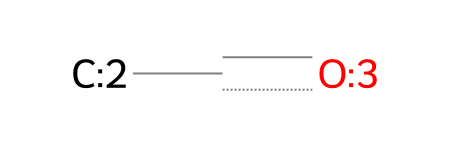

In [41]:
# Initialize a set to collect all atom indices in the environment
atom_indices = set()

substrate_mol = Chem.MolFromSmarts('[CH3:1][CH2:2][OH:3]')

env = Chem.FindAtomEnvironmentOfRadiusN(substrate_mol, 
                                        radius = 1, 
                                        rootedAtAtom = 2,
                                          atomMap = {'C':3,
                                                     'C':4,
                                                     'O':6})

Chem.PathToSubmol(substrate_mol, env)

In [2]:
def get_template_without_aligning_atom_maps(atom_mapped_substrate_smarts: str, 
                                           radius: int, 
                                           reactive_atom_indices: List[str]) -> str:

    substrate_mol = Chem.MolFromSmarts(atom_mapped_substrate_smarts)
    if substrate_mol is None:
        raise ValueError("Invalid SMARTS string provided.")
    
    # Initialize a set to collect all atom indices in the environment
    atom_indices = set()

    # Loop through each reactive atom and find its environment
    for atom_idx in reactive_atom_indices:
        reaction_environment = Chem.FindAtomEnvironmentOfRadiusN(
            mol=substrate_mol, 
            radius=radius, 
            rootedAtAtom=atom_idx
        )
        
        # Collect atom indices from the bonds in this environment
        for bond_idx in reaction_environment:
            bond = substrate_mol.GetBondWithIdx(bond_idx)
            atom_indices.add(bond.GetBeginAtomIdx())
            atom_indices.add(bond.GetEndAtomIdx())

    # Generate the SMARTS string for the combined environment
    env_smarts = Chem.MolFragmentToSmarts(
        substrate_mol, 
        atomsToUse=list(atom_indices)
    )
    
    return env_smarts

In [3]:
def get_template_after_aligning_atom_maps(atom_mapped_substrate_smarts: str,
                                          radius: int,
                                          reactive_atom_indices: List[str]):
    
    substrate_mol = Chem.MolFromSmarts(atom_mapped_substrate_smarts)
    if substrate_mol is None:
        raise ValueError("Invalid SMARTS string provided.")

    # initialize a set to store the union of all combined atom environments
    combined_env = set()

    # process each reactive site
    for map_num in reactive_atom_indices:
        # find the atom index corresponding to the atom map number
        rooted_atom_index = None
        for atom in substrate_mol.GetAtoms():
            if atom.GetAtomMapNum() == map_num:
                rooted_atom_index = atom.GetIdx()
                break

        if rooted_atom_index is None:
            raise ValueError(f"Atom with map number {map_num} not found!")

        # find the atom environment of the current atom
        env = Chem.FindAtomEnvironmentOfRadiusN(substrate_mol, radius = radius, rootedAtAtom = rooted_atom_index)
        combined_env.update(env)

    # after all combined environments have been collected, convert to a sub-molecule
    combined_submol = Chem.PathToSubmol(substrate_mol, list(combined_env))

    # propagate atom map numbers to the sub-molecule
    for atom in combined_submol.GetAtoms():
        original_atom = substrate_mol.GetAtomWithIdx(atom.GetIdx())
        atom.SetAtomMapNum(original_atom.GetAtomMapNum())

    return Chem.MolToSmarts(combined_submol)

#### Ethanol example:

Now, consider the simple example of ethanol with the following atom-map:

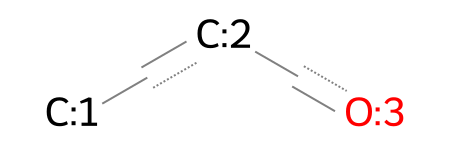

In [4]:
Chem.MolFromSmarts('[CH3:1][CH2:2][OH:3]')

If we use the function `get_template_without_aligning_atom_maps` and anchor this at carbon C2, then we would expect both the atoms C1 and O3 to appear in the resulting template. However, C1 does not appear:

In [7]:
template = get_template_without_aligning_atom_maps(atom_mapped_substrate_smarts = '[CH3:1][CH2:2][OH:3]',
                                                   radius = 1,
                                                   reactive_atom_indices = [2])

template

'[C&H2:2][O&H1:3]'

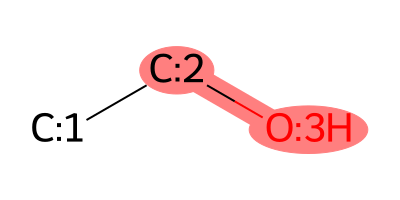

In [8]:
draw.highlight_substructures_in_notebook(substrate_smarts = "[CH3:1][CH2:2][OH:3]",
                                          substructure_smarts = template)

Instead, let's try using the function `get_template_after_aligning_atom_maps` and again, we anchor this at carbon C2. Now, we find the C1 does appear in the resulting template:

In [9]:
template = get_template_after_aligning_atom_maps(atom_mapped_substrate_smarts = '[CH3:1][CH2:2][OH:3]',
                                                   radius = 1,
                                                   reactive_atom_indices = [2])

template

'[C&H3:1][C&H2:2][O&H1:3]'

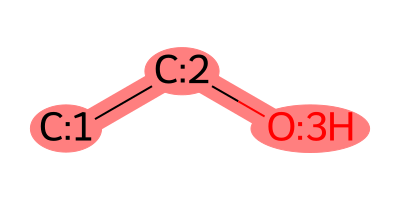

In [10]:
draw.highlight_substructures_in_notebook(substrate_smarts = "[CH3:1][CH2:2][OH:3]",
                                          substructure_smarts = template)

#### Mandelonitrile example:

Now, consider a slightly more involved example involving mandelonitrile:

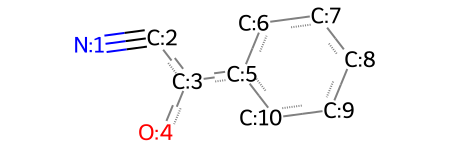

In [15]:
mandelonitrile_smarts = '[N:1]#[C:2][C@H:3]([OH:4])[c:5]1[cH:6][cH:7][cH:8][cH:9][cH:10]1'

Chem.MolFromSmarts(mandelonitrile_smarts)

This time, let's start at the carbon atom with index 3, i.e. C3. If we were to go 1 bond around C3, we would expect the atoms C2, O4, and C5 to be encapsulated within the resulting substructure. Using the function `get_template_without_aligning_atom_maps`, however, we get a slightly different environment back:

In [16]:
template = get_template_without_aligning_atom_maps(atom_mapped_substrate_smarts = mandelonitrile_smarts,
                                                   radius = 1,
                                                   reactive_atom_indices = [3])

template

'[O&H1:4][C@&H1:3]'

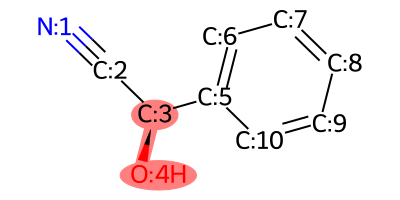

In [17]:
draw.highlight_substructures_in_notebook(substrate_smarts = mandelonitrile_smarts,
                                          substructure_smarts = template)

Let's intead use the function `get_template_after_aligning_atom_maps`:

In [18]:
template = get_template_after_aligning_atom_maps(atom_mapped_substrate_smarts = mandelonitrile_smarts,
                                                   radius = 1,
                                                   reactive_atom_indices = [3])

template

'[C:1][C@&H1:2]([O&H1:3])[c:4]'

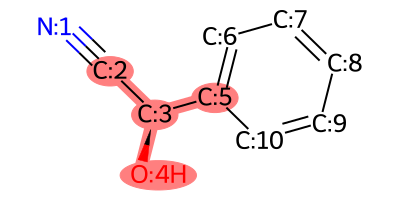

In [19]:
draw.highlight_substructures_in_notebook(substrate_smarts = mandelonitrile_smarts,
                                          substructure_smarts = template)

Here, our desired substructure has been captured corretly. So the crucial takeway is to align any external atom-map with RDKit's interal map of atom indices.